In [1]:
import sys
sys.path.append("./source")
import bier
from lmmNet import *
import train_onestep
import predict_onestep
import predict_lmmNet

import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt
import timeit

# 1. Stable Fixed Point

TODO: generate multiple strains of S. cerevisiae. The strategy is to create multiple dataframes with `create_data(...)` from `utils` and concatenate them afterwards.

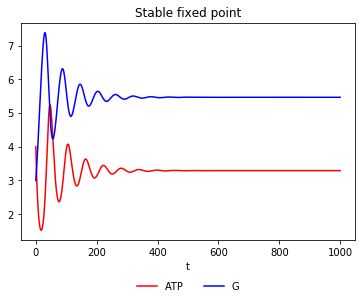

In [8]:
time_points, bier_data1 = bier.simulate_custom()

plt.plot(time_points, bier_data1[:,0], 'r-', label='ATP')
plt.plot(time_points, bier_data1[:,1], 'b-', label='G')
plt.xlabel('t')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)
plt.title('Stable fixed point')
plt.show()

In [9]:
# function to prepare data for training one-step method
from utils import *

feature_list = [] # here we do not have external time-series or control variables
target_list = ['ATP', 'Glucose']

# now generate and augment the training dataset
df1 = create_data_numpy(bier_data1, time_points, cols=target_list)

# create another training strain and one test strain
time_points, bier_test = bier.simulate_custom(x0 = [3, 6])
time_points, bier_data2 = bier.simulate_custom(x0 = [2,1])

df2 = create_data_numpy(bier_data2, time_points, cols=target_list, num=1)
test_df = create_data_numpy(bier_test, time_points, cols=target_list)
df = pd.concat([df1, df2])

Shape of the dataframe is: (5000, 3)
Shape of the dataframe is: (5000, 3)
Shape of the dataframe is: (5000, 3)


ATP


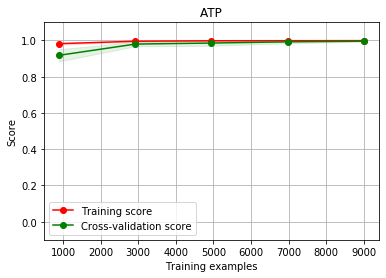

Target: ATP, CV Pearson R2 coefficient: 0.999419
Glucose


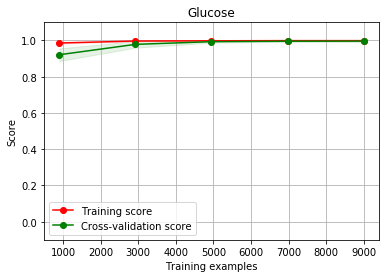

Target: Glucose, CV Pearson R2 coefficient: 0.999253
Average training score: 0.9993360247634722
ATP RMSE: -8.005664763361071e-05 standard deviation: 0.0018253619382587755


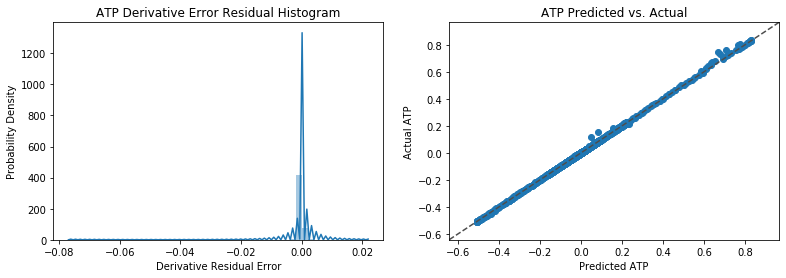

Glucose RMSE: 7.299596186725935e-05 standard deviation: 0.0018962724416243231


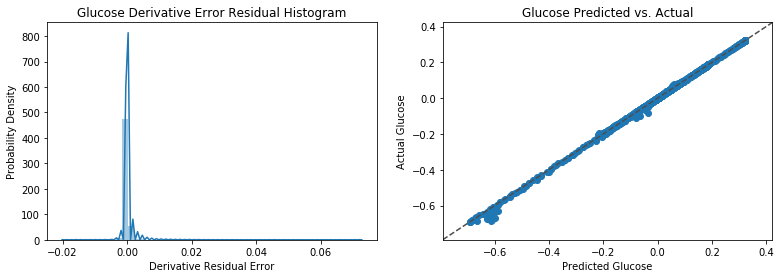

Total Derivative Mean Error: 0.012067895547533533 Error Standard Deviation: 0.013380573671431254


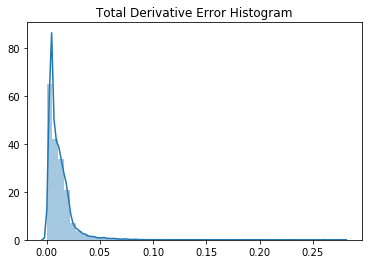

Real data:


,ATP,Glucose
Strain,,
0,3.000000,6.000000
0,3.010724,5.999872
0,3.021561,5.999488
0,3.032506,5.998850
0,3.043554,5.997956
...,...,...
0,3.292683,5.466668
0,3.292683,5.466668
0,3.292683,5.466668


Predicted data:


,ATP,Glucose
Time,,
0.0,3.000000,6.000000
0.2,3.014584,5.999621
0.4,3.029508,5.998742
0.6,3.044805,5.997292
0.8,3.060599,5.994739
...,...,...
999.0,3.287510,5.470521
999.2,3.287538,5.470540
999.4,3.287566,5.470558


./source/predict_onestep.py:217: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_onestep.py:222: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: ATP 0.7600245389549479 RMSE percentage: 6.214099333434999
ML Fit: Glucose 0.6599026187508071 RMSE percentage: 4.493633816568667
ML model aggregate error
Average RMSE: 0.7099635788528775
Total percentage error: 5.353866575001833


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


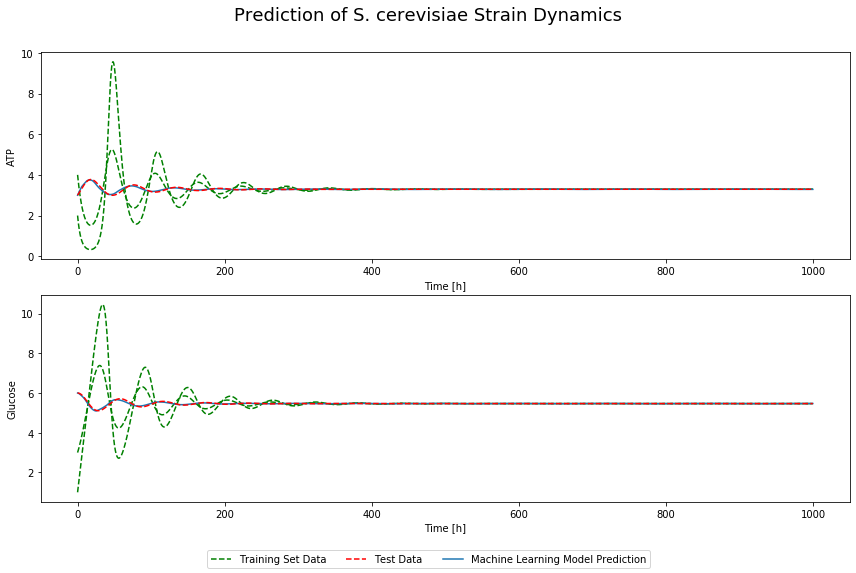

In [10]:
df_train = train_onestep.generate_dataset(df, [0, 1],feature_list, target_list, n_dim=5000)
tp, pred = end_to_end_training(df, df_train, test_df, feature_list, target_list, (2,1), title='S. cerevisiae')

# 2. Stable limit cycle

Now let's try to solve the oscillating problem. Make sure to import the necessary libraries.

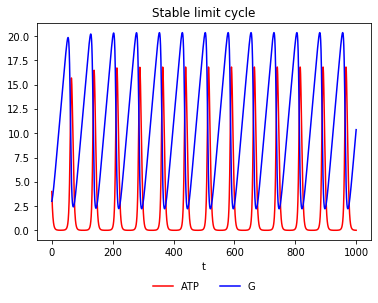

In [11]:
time_points, bier_data = bier.simulate_default()

plt.plot(time_points, bier_data[:,0], 'r-', label='ATP')
plt.plot(time_points, bier_data[:,1], 'b-', label='G')
plt.xlabel('t')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)
plt.title('Stable limit cycle')
plt.show()

In [17]:
# function to prepare data for training one-step method
# now generate and augment the training dataset
df = create_data_numpy(bier_data, time_points, cols=target_list)
df_train = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=5000)

Shape of the dataframe is: (5000, 3)


Shape of the dataframe is: (10000, 3)
ATP


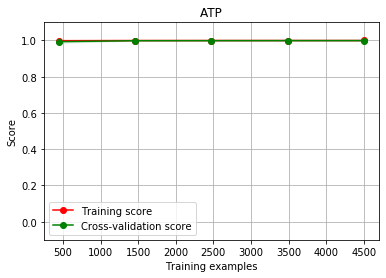

Target: ATP, CV Pearson R2 coefficient: 0.999907
Glucose


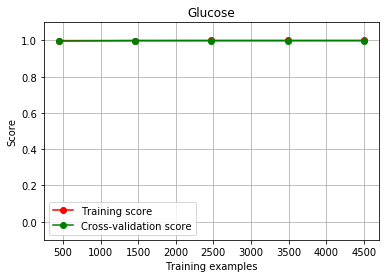

Target: Glucose, CV Pearson R2 coefficient: 0.999953
Average training score: 0.9999299179659726
ATP RMSE: 0.0004609466934860147 standard deviation: 0.007954318925421394


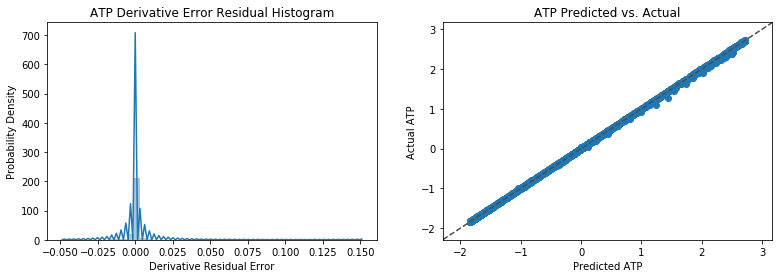

Glucose RMSE: -0.00023550836225313924 standard deviation: 0.004765567570012352


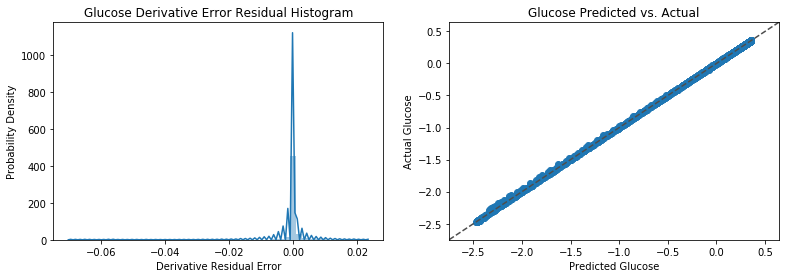

Total Derivative Mean Error: 0.022891357605010574 Error Standard Deviation: 0.03590928562389662


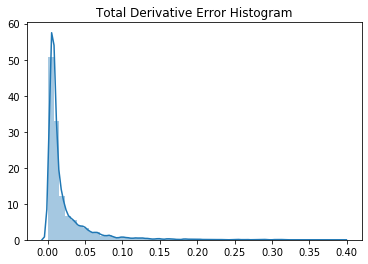

In [ ]:
# create a test data
time_points, bier_test = bier.simulate_custom(x0 = [2,1],h = 0.1, params={'Vin': 0.36, 'k1': 0.02, 'kp':6, 'km':12})
test_df = create_data_numpy(bier_test, time_points, cols=target_list)

tp, pred = end_to_end_training(df, df_train, test_df, feature_list, target_list, (2,1), title='S. cerevisiae')

Text(0.5, 1.0, 'Phase plane of 2D Yeast Glycolytic Oscillator')

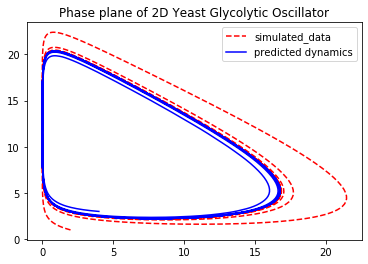

In [14]:
# Phase plane

plt.plot(bier_test[:,0], bier_test[:,1], 'r--', label='simulated_data')
plt.legend()
plt.plot(pred['ATP'], pred['Glucose'], 'b-', label='predicted dynamics')
plt.legend()
plt.title('Phase plane of 2D Yeast Glycolytic Oscillator')

In [15]:
bier_test[:5,:]

array([[2.        , 1.        ],
       [1.85006566, 1.06406026],
       [1.7107021 , 1.12826074],
       [1.58129415, 1.192627  ],
       [1.46124394, 1.25717975]])

# 3. LmmNet

Interestingly, just 1 strain is enough for LmmNet to perform well on the test data.

# 4. Results

The performance on 2-D Harmonic oscillator is taken from [MultiStep Neural Network](https://maziarraissi.github.io/research/7_multistep_neural_networks/).

In [10]:
# first component MSE
harmonic1_ab = [1.5, 0.031, 0.12, 0.043, 0.012]
harmonic1_am = [0.0088, 0.012, 0.016, 0.0063, 0.011]
harmonic1_bdf = [1.3, 0.0088, 0.013, 0.014, 0.017]

# second component MSE
harmonic2_ab = [1.5, 0.03, 0.097, 0.035, 0.012]
harmonic2_am = [0.0083, 0.01, 0.016, 0.0058, 0.011]
harmonic2_bdf = [1.3, 0.0086, 0.0099, 0.014, 0.015]

In [27]:
def compute_MSE(pred, data, index):
    pred_array = np.array(pred)
    data = np.squeeze(data)
    return np.linalg.norm(data[:,index] - pred_array[:,index], 2)/np.linalg.norm(data[:,index], 2)

Next we compute the MSE from the 2-D Yeast Glycolytic Oscillator results.

In [28]:
# first component
glycolytic1_ab = [compute_MSE(result_dict['AB'+str(i)+'pred'], bier_data, 0) for i in range(1, 6)]
glycolytic1_am = [compute_MSE(result_dict['AM'+str(i)+'pred'], bier_data, 0) for i in range(1, 6)]
glycolytic1_bdf = [compute_MSE(result_dict['BDF'+str(i)+'pred'], bier_data, 0) for i in range(1, 6)]

# second component
glycolytic2_ab = [compute_MSE(result_dict['AB'+str(i)+'pred'], bier_data, 1) for i in range(1, 6)]
glycolytic2_am = [compute_MSE(result_dict['AM'+str(i)+'pred'], bier_data, 1) for i in range(1, 6)]
glycolytic2_bdf = [compute_MSE(result_dict['BDF'+str(i)+'pred'], bier_data, 1) for i in range(1, 6)]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


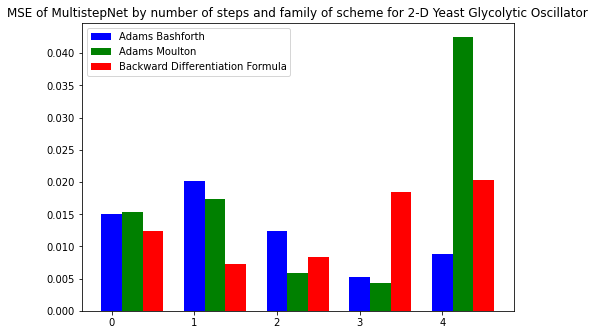

In [44]:
data = [glycolytic1_ab, glycolytic1_am, glycolytic1_bdf]
X = np.arange(5)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)

ax.set_xticks(X, ('G1', 'G2', 'G3', 'G4', 'G5'))
ax.set_title('MSE of MultistepNet by number of steps and family of scheme for 2-D Yeast Glycolytic Oscillator')
ax.legend(labels=['Adams Bashforth', 'Adams Moulton', 'Backward Differentiation Formula'])

plt.show()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


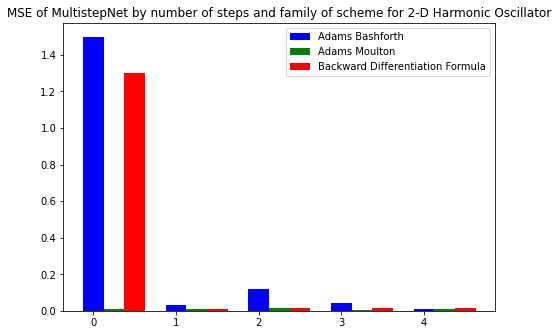

In [43]:
data = [harmonic1_ab, harmonic1_am, harmonic1_bdf]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)

ax.set_xticks(X, ('G1', 'G2', 'G3', 'G4', 'G5'))
ax.set_title('MSE of MultistepNet by number of steps and family of scheme for 2-D Harmonic Oscillator')
ax.legend(labels=['Adams Bashforth', 'Adams Moulton', 'Backward Differentiation Formula'])
plt.show()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


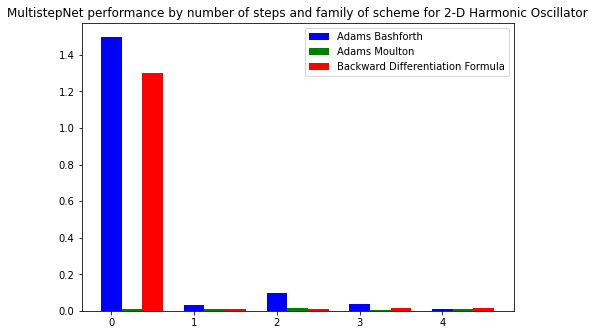

In [41]:
data = [harmonic2_ab, harmonic2_am, harmonic2_bdf]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)

ax.set_xticks(X, ('G1', 'G2', 'G3', 'G4', 'G5'))
ax.set_title('MultistepNet performance by number of steps and family of scheme for 2-D Harmonic Oscillator')
ax.legend(labels=['Adams Bashforth', 'Adams Moulton', 'Backward Differentiation Formula'])
plt.show()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


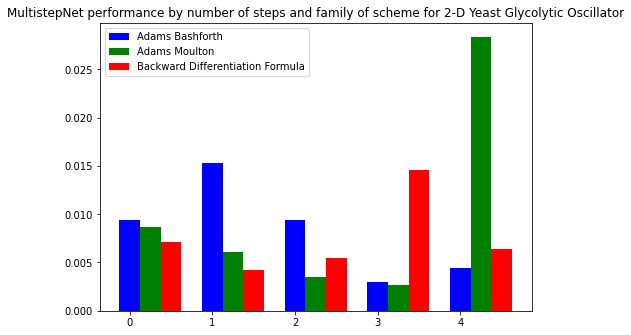

In [42]:
data = [glycolytic2_ab, glycolytic2_am, glycolytic2_bdf]
X = np.arange(5)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)

ax.set_xticks(X, ('G1', 'G2', 'G3', 'G4', 'G5'))
ax.set_title('MultistepNet performance by number of steps and family of scheme for 2-D Yeast Glycolytic Oscillator')
ax.legend(labels=['Adams Bashforth', 'Adams Moulton', 'Backward Differentiation Formula'])

plt.show()